In [77]:
from pprint import pprint
from time import time
import numpy as np
import scipy as sp
import itertools
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# `2 Applied ML`

## `2(1)`

`Load the 20newsgroup Dataset`

In [18]:
newsgroup = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

print("%d documents" % len(newsgroup.filenames))
print("%d categories" % len(newsgroup.target_names))

11314 documents
20 categories


`Compute vectors using TF-IDF scores`

In [19]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroup.data)

print("%d vectors" % len(vectors.todense()))

11314 vectors


`Pair category of each article`

In [20]:
catregory_ref = dict()
for i,k  in enumerate(newsgroups_train['target_names']):
    catregory_ref[k] = i

In [32]:
extract_category = lambda filename: catregory_ref[filename.split("/")[6]]
category_func = np.vectorize(extract_category)
category = np.transpose(csr_matrix(category_func(newsgroup['filenames'])))

`Split the data into train, validation and test sets`

In [42]:
x = vectors
y = category
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.11)

print("%d articles in train dataset" % len(x_train.todense()))
print("%d articles in validation dataset" % len(x_validation.todense()))
print("%d articles in test dataset" % len(x_test.todense()))


9061 articles in train dataset
1121 articles in validation dataset
1132 articles in test dataset


## `2(2)`

In [55]:
def random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(x_train.todense(), np.ravel(y_train.todense()))
    
    return accuracy_score(y_validation.todense(), clf.predict(x_validation.todense()))

`Grid search on max_depth and n_estimators`

In [61]:
n_estimators_list = [50,90,110]
max_depth_list = [50,90,110]

best_param = {'n_estimators': 0,
              'max_depth': 0}

max_acc = 0.

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        acc = random_forest_accuracy(x_train, y_train, x_validation, y_validation, max_depth, n_estimators)
        print("Accuracy = %f for n_estimators = %d, max_depth = %d"%(acc,n_estimators,max_depth))
        if acc > max_acc:
            max_acc = acc
            best_param['n_estimators'] = n_estimators
            best_param['max_depth'] = max_depth

print('The best accuracy score %f is obtained by parameters %s.'%(max_acc,str(best_param)))

Accuracy = 0.048171 for n_estimators = 1, max_depth = 1
Accuracy = 0.073149 for n_estimators = 1, max_depth = 2
Accuracy = 0.073149 for n_estimators = 1, max_depth = 3
Accuracy = 0.057984 for n_estimators = 2, max_depth = 1
Accuracy = 0.069581 for n_estimators = 2, max_depth = 2
Accuracy = 0.083854 for n_estimators = 2, max_depth = 3
Accuracy = 0.082070 for n_estimators = 3, max_depth = 1
Accuracy = 0.074041 for n_estimators = 3, max_depth = 2
Accuracy = 0.109723 for n_estimators = 3, max_depth = 3
The best accuracy score 0.109723 is obtained by parameters {'n_estimators': 3, 'max_depth': 3}.


## `<Alternative Solution>`

`Create pipeline with TfidfVectorizer() and RandomForestClassifier()`

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier()),
])

`Grid search on max_depth and n_estimators`

In [ ]:
parameters = {
    'clf__n_estimators': (70, 90, 110),
    'clf__max_depth': (70, 90, 110),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(x_train.todense(), y_train.todense())

print("Best accuracy score: %0.f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

## `</Alternative Solution>`

`Train the model w/ best parameters and display a confusion matrix`

In [64]:
clf = RandomForestClassifier(max_depth=90, n_estimators=110)
clf.fit(x_train.todense(), np.ravel(y_train.todense()))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.4   0.02  0.    0.    0.    0.    0.    0.04  0.02  0.13  0.    0.    0.
   0.    0.    0.31  0.02  0.02  0.02  0.  ]
 [ 0.    0.66  0.12  0.06  0.    0.04  0.    0.02  0.02  0.02  0.04  0.    0.
   0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.62  0.07  0.02  0.11  0.04  0.02  0.    0.11  0.    0.
   0.02  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.05  0.14  0.63  0.03  0.03  0.05  0.02  0.    0.03  0.    0.
   0.02  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.06  0.04  0.09  0.63  0.04  0.03  0.01  0.    0.04  0.    0.
   0.03  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.1   0.05  0.    0.    0.84  0.    0.    0.    0.    0.    0.
   0.02  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.79  0.06  0.04  0.06  0.    0.    0.
   0.    0.04  0.    0.02  0.    0.    0.  ]
 [ 0.    0.04  0.02  0.02  0.    0.    0.02  0.62  0.1   0.12  0.    0.
   0.02  0.02  0.    0.02  0.02  0.    

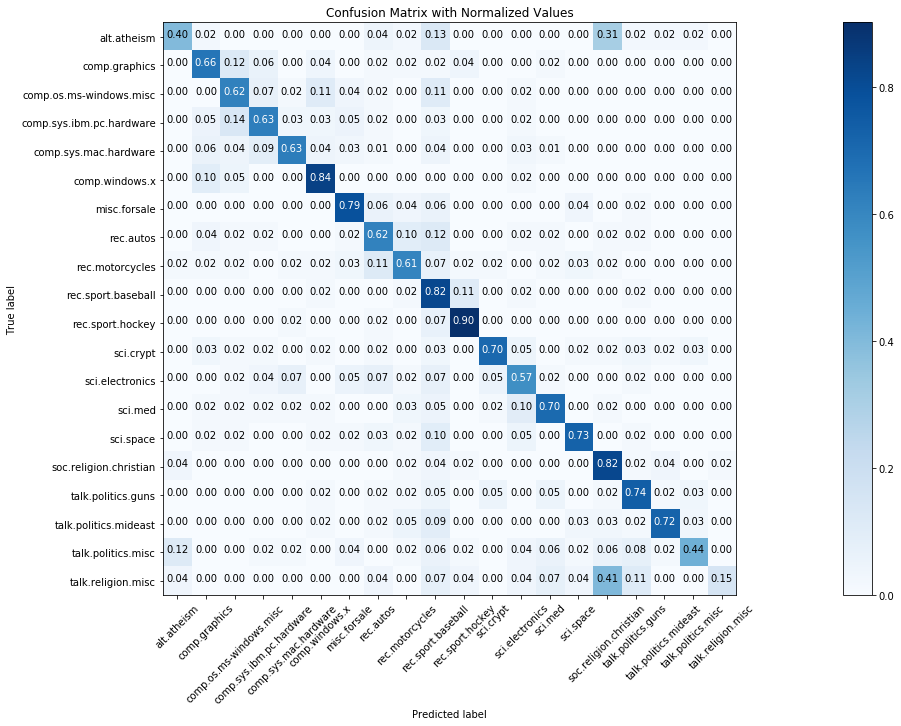

In [88]:
cnf_matrix = confusion_matrix(y_validation.todense(), clf.predict(x_validation.todense()))
np.set_printoptions(precision=2)

plt.figure(figsize=(30,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroup.target_names, normalize=True,
                      title='Confusion Matrix with Normalized Values')

`Inspect the feature_importances_ attribute of the random forest`

In [89]:
clf.feature_importances_

array([  6.84e-04,   2.20e-04,   1.11e-07, ...,   5.08e-06,   4.80e-06,
         2.43e-06])

`[Discuss]`